In [60]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import math
import pickle
import time

from docplex.mp.model import Model


import networkx
import folium
import geopy
from datetime import datetime
import googlemaps
from geopy.geocoders import Bing 
from folium.plugins import TimestampedGeoJson
import polyline
import json

#Google API
gkey='Your API KEY'
gmaps = googlemaps.Client(key=gkey)
#Bing API
bkey='AYour API KEY'
b=Bing(bkey,timeout=5)

In [61]:
def google_geocode(address):
    """ use google api to latitude and longitude """
    geocode_result = gmaps.geocode(address)
    location = geocode_result[0]['geometry']['location']
    formatted_address = geocode_result[0]['formatted_address']
    
    return location,formatted_address

In [62]:
def get_distance_bing(lat0,lon0,lat1,lon1):
    """ use bing api to get pairwise distance in km """
    routeUrl = "http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=" + str(lat0) + "," + str(lon0) + "&wp.1=" +  str(lat0) + "," + str(lon1)  + "&key=" + key
    print(routeUrl)
    request = urllib.request.Request(routeUrl)
    response = urllib.request.urlopen(request,timeout=15)
    a=response.read().decode(encoding="utf-8")
    result = json.loads(a)
    distance=result["resourceSets"][0]["resources"][0]["travelDistance"]
        
    return distance

In [63]:
def get_distance_gmaps(lat0,lon0,lat1,lon1):
    """ use google api to calculate pairwise driving distanc, traffic is based on 'now' """
    now = datetime.now()
    directions_result = gmaps.directions([lat0,lon0],[lat1,lon1], mode="transit",departure_time=now)
    print(directions_result)
    dm = directions_result[0]['legs'][0]['distance']['value'] #total distance in m
    ds = directions_result[0]['legs'][0]['duration']['value'] #duration (not considering traffic)
    dp = directions_result[0]['overview_polyline']['points'] #for plotting total polyline
    return dm,ds,dp

In [64]:
# Note: index zero is the location of the depot
df = pd.read_excel('incheon.xlsx',index_col=[0])
df.head()

,Nome,Indirizzo,Quantita,Location,Latitude,Longitude
Numero,,,,,,
0,처리장,625-64 Namchon-dong,NaN,625-64 Namchon-dong,37.430432,126.716640
1,SK스카이뷰,"604 Yonghyeon 5(o)-dong, Nam-gu, Incheon",5.090209,"604 Yonghyeon 5(o)-dong, Nam-gu, Incheon",37.450199,126.645169
2,용현금호타운2단지,"68 Maesohol-ro, Yonghyeon 5(o)-dong, Nam-gu, I...",6.736201,"68 Maesohol-ro, Yonghyeon 5(o)-dong, Nam-gu, I...",37.448388,126.633418
3,용현금호타운,"9 Nakseomdong-ro, Nam-gu, Incheon",0.101200,"9 Nakseomdong-ro, Nam-gu, Incheon",37.449844,126.632281
4,신창미션힐아파트,"627-534 Yonghyeon 5(o)-dong, Nam-gu, Incheon",6.407258,"627-534 Yonghyeon 5(o)-dong, Nam-gu, Incheon",37.445141,126.642554


In [65]:
# If not empty (i.e. non nan, default from loading empty cells in excel) use API geocode function
df['Location']=df.apply(lambda x: x['Location'] if isinstance(x['Location'], str) else google_geocode(x['Indirizzo']), axis=1)

# Populate table
df['Latitude']=df.apply(lambda x: x['Latitude'] if not math.isnan(x['Latitude']) else x['Location'][0]['lat'], axis=1)
df['Longitude']=df.apply(lambda x: x['Longitude'] if not math.isnan(x['Longitude']) else x['Location'][0]['lng'], axis=1)
df['Location']=df.apply(lambda x: x['Location'] if len(x['Location'])>2 else x['Location'][1], axis=1)

In [66]:
m = folium.Map(
    location=[37.4500, 126.6535],
    zoom_start=13
)

df.apply(lambda x:folium.CircleMarker(location=[x["Latitude"], x["Longitude"]], radius=10).add_to(m), axis=1)
m

In [67]:
#clients tot - depot
n=df.shape[0]-1
clients=[i for i in range(1,n+1)]
#nodes
nodes=[0] + clients
#capacity van
C=40
#arcs
arcs=[(i,j) for i in nodes for j in nodes if i!=j]

q={i:np.random.randint(1,10) for i in clients}

print('Clients =' + str(n))
print('# Arcs = ' + str(len(arcs)))

Clients =20
# Arcs = 420


In [68]:
dist_s={} #dictionary with distance in seconds
dist_m={} #dictionary with distance in seconds
dist_p={} #dictionary with polylines for plotting

for i in arcs:
    s,m,p=get_distance_gmaps(df['Latitude'][i[0]],df['Longitude'][i[0]],df['Latitude'][i[1]],df['Longitude'][i[1]])
    dist_s[i] = s
    dist_m[i] = m
    dist_p[i] = p

out=[dist_s,dist_m,dist_p]

with open("distance_matrix.txt", "wb") as f:
    pickle.dump(out, f)

[{'bounds': {'northeast': {'lat': 37.450199, 'lng': 126.718812}, 'southwest': {'lat': 37.4293062, 'lng': 126.645169}}, 'copyrights': 'Map data ©2022 TMap Mobility', 'legs': [{'arrival_time': {'text': '7:20pm', 'time_zone': 'Asia/Seoul', 'value': 1650709215}, 'departure_time': {'text': '6:20pm', 'time_zone': 'Asia/Seoul', 'value': 1650705657}, 'distance': {'text': '9.5 km', 'value': 9546}, 'duration': {'text': '59 mins', 'value': 3558}, 'end_address': '294-5 Yonghyeon-dong, Nam-gu, Incheon, South Korea', 'end_location': {'lat': 37.450199, 'lng': 126.645169}, 'start_address': '651 Namchon-dong, Namdong-gu, Incheon, South Korea', 'start_location': {'lat': 37.430432, 'lng': 126.71664}, 'steps': [{'distance': {'text': '0.2 km', 'value': 206}, 'duration': {'text': '3 mins', 'value': 207}, 'end_location': {'lat': 37.429307, 'lng': 126.718497}, 'html_instructions': 'Walk to Namchon Poonglim Apt. III', 'polyline': {'points': 'esmcF_jldW~EsJ'}, 'start_location': {'lat': 37.430432, 'lng': 126.716

In [69]:
with open("distance_matrix.txt", "rb") as f: 
    dist_mat_list = pickle.load(f)

distance=dist_mat_list[0]

In [70]:
mdl=Model('CVRP')

mdl.parameters.timelimit=120 #Two minutes timeout if does not reach a optimal solution

x=mdl.binary_var_dict(arcs,name='x')
u=mdl.continuous_var_dict(nodes,ub=C,name='u')
# cost function is to minimize tot distance (could minimize time or a combined score)
mdl.minimize(mdl.sum(distance[i,j]*x[i,j] for i,j in arcs )) 

In [71]:
# Add contrains for CVRP
mdl.add_constraints(mdl.sum(x[i,j] for j in nodes if i!=j)==1 for i in clients);
mdl.add_constraints(mdl.sum(x[i,j] for i in nodes if i!=j)==1 for j in clients);
mdl.add_constraints(u[i]>=q[i] for i in clients);
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i,j],u[i]+q[j]==u[j])
                              for i,j in arcs if i!= 0 and  j!= 0);

In [72]:
# Print model
print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CVRP

Minimize
 obj: 9546 x_0_1 + 10977 x_0_2 + 11105 x_0_3 + 10155 x_0_4 + 11090 x_0_5
      + 11126 x_0_6 + 11411 x_0_7 + 11507 x_0_8 + 11153 x_0_9 + 11369 x_0_10
      + 12247 x_0_11 + 10976 x_0_12 + 11904 x_0_13 + 11628 x_0_14 + 10547 x_0_15
      + 11493 x_0_16 + 11487 x_0_17 + 11553 x_0_18 + 11620 x_0_19 + 10358 x_0_20
      + 9363 x_1_0 + 2015 x_1_2 + 1839 x_1_3 + 1214 x_1_4 + 1500 x_1_5
      + 1001 x_1_6 + 1081 x_1_7 + 1407 x_1_8 + 660 x_1_9 + 1664 x_1_10
      + 1467 x_1_11 + 2230 x_1_12 + 594 x_1_13 + 888 x_1_14 + 1278 x_1_15
      + 880 x_1_16 + 960 x_1_17 + 946 x_1_18 + 1336 x_1_19 + 1237 x_1_20
      + 10803 x_2_0 + 1597 x_2_1 + 401 x_2_3 + 1223 x_2_4 + 466 x_2_5
      + 2842 x_2_6 + 1009 x_2_7 + 1700 x_2_8 + 1491 x_2_9 + 1957 x_2_10
      + 710 x_2_11 + 2523 x_2_12 + 1518 x_2_13 + 1207 x_2_14 + 754 x_2_15
      + 1168 x_2_16 + 1068 x_2_17 + 1046 x_2_18 + 1629 x_2_19 + 936 x_2_20
      + 10960 

In [73]:
import cplex
solution=mdl.solve(log_output=True)

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Found incumbent of value 443672.000000 after 0.00 sec. (0.04 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 20 rows and 1 columns.
MIP Presolve modified 190 coefficients.
Aggregator did 190 substitutions.
Reduced MIP has 230 rows, 630 columns, and 1370 nonzeros.
Reduced MIP has 420 binaries, 0 generals, 0 SOSs, and 380 indicators.
Presolve time = 0.00 sec. (1.59 ticks)
Probing time = 0.02 sec. (2.59 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 230 rows, 630 columns, and 1370 nonzeros.
Reduced MIP has 420 binaries, 0 generals, 0 SOSs, and 380 indicators.
Presolve time = 0.00 sec. (0.96 ticks)
Probing time = 0.00 sec. (2.12 ticks)
Clique table members: 230.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 6 threads.
Roo

In [74]:
mdl.get_solve_status()

<JobSolveStatus.FEASIBLE_SOLUTION: 1>

In [75]:
solution.display()

solution for: CVRP
objective: 72609
x_0_4 = 1
x_0_9 = 1
x_0_15 = 1
x_1_0 = 1
x_2_3 = 1
x_3_11 = 1
x_4_17 = 1
x_5_2 = 1
x_6_0 = 1
x_7_14 = 1
x_8_19 = 1
x_9_18 = 1
x_10_12 = 1
x_11_8 = 1
x_12_6 = 1
x_13_1 = 1
x_14_20 = 1
x_15_5 = 1
x_16_13 = 1
x_17_7 = 1
x_18_16 = 1
x_19_10 = 1
x_20_0 = 1
u_1 = 24.000
u_2 = 9.000
u_3 = 13.000
u_4 = 12.000
u_5 = 5.000
u_6 = 40.000
u_7 = 30.000
u_8 = 18.000
u_9 = 2.000
u_10 = 34.000
u_11 = 14.000
u_12 = 36.000
u_13 = 17.000
u_14 = 38.000
u_15 = 4.000
u_16 = 14.000
u_17 = 21.000
u_18 = 10.000
u_19 = 26.000
u_20 = 40.000


[[0, 4, 17, 7, 14, 20, 0],
 [0, 15, 5, 2, 3, 11, 8, 19, 10, 12, 6, 0],
 [0, 9, 18, 16, 13, 1, 0]]

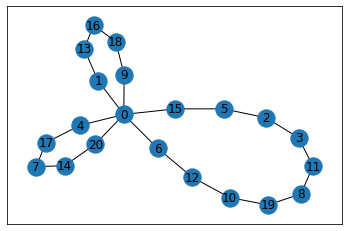

In [76]:
#Arcs that are actually travelled
active_arcs = [a for a in arcs if x[a].solution_value > 0.9]

G=networkx.Graph(active_arcs)
labels = dict(zip(G.nodes(),G.nodes()))

networkx.draw_networkx(G,labels=labels)
networks=networkx.cycle_basis(G,0)
networks = [[0]+i for i in networks] 
networks

In [77]:
geo_list=[]
times=dist_mat_list[1]
poly=dist_mat_list[2]

colors=['red','green','blue','black','tomato','coral','grey']
t=0
ot=1587575480566

for i,j in enumerate(networks):

    print(j)
    for k in range(0,len(j)-1):
        temp={}
        t=t+3600000
        idx=poly.get((j[k],j[k+1]))
        pp=polyline.decode(idx)
        swap=[ [pp[i][1],pp[i][0]] for i in range(0,len(pp)) ] #because geojson wants Lng and Lat in order
        temp['coordinates']=swap
        temp['dates']=[ot+t, ot+500+t]*len(pp)
        temp['color']=colors[i]
        geo_list=geo_list+[temp]
              
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': line['weight'] if 'weight' in line else 3
            }
        }
    }
    for line in geo_list
]


#Create Folium Map
m = folium.Map(
    location=[37.4500, 126.6535],
    zoom_start=13
)

df.apply(lambda x:folium.CircleMarker(location=[x["Latitude"], x["Longitude"]], radius=10).add_to(m), axis=1)

TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT1H', add_last_point=False).add_to(m)

m  

[0, 4, 17, 7, 14, 20, 0]
[0, 15, 5, 2, 3, 11, 8, 19, 10, 12, 6, 0]
[0, 9, 18, 16, 13, 1, 0]
